In [26]:
#%reset
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np
import os 
from matplotlib.patches import Polygon
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from eli5.sklearn import PermutationImportance
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
from Functions_AMR_gonorrhea import effective_unnecessary_threshold, get_best_hyperparameters, get_best_features, get_test_train_data, get_feature_effects, f1_mcc_score_threshold
hfont = {'fontname':'Helvetica'}

## read data 
CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")
print(CIP_data_no_drop.columns)

Index(['Unnamed: 0.4', 'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1',
       'Unnamed: 0', 'CLINIC', 'YEAR', 'GENDERSP', 'Susceptible', 'MSM',
       'MSMW', 'MSW', 'Oth/Unk/Missing', 'REGION', 'Midwest', 'Northeast',
       'Southeast', 'Southwest', 'West', 'PREV_REGION', 'PREV_CLINIC',
       'DELTA_REGION', 'DELTA_CLINIC'],
      dtype='object')


In [39]:
################################ Get hyperparameters and best features for each model  ###########################
#### Loop set up 
threshold_seq = np.linspace(0,1,101)
test_years = [2005, 2006, 2007, 2008, 2009, 2010]  #np.array(range(2005, 2011))
test_years = [2005]
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42) #need for neural network and random forest
model_types = ["Logistic_regression", "Neural_network", "Random_forest"]
i = 0

# logistic regression - random initial parameters
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')
# random forest - random initial parameters
model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)
# neural network - random parameters
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =1.291549665014884, random_state=10, learning_rate = 'adaptive' )
unfitted_models = [model_lr, model_rf, model_nn]

### Hyperparameter tuning
cv = RepeatedStratifiedKFold(n_splits=10, random_state=1) ## 10-fold cross validations
# logistic regression 
space_lr = dict()
space_lr['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space_lr['penalty'] = ['l1', 'l2']
space_lr['C'] = np.arange(0, 100, .01)
best_hyperparameters_by_year_lr = {}
# random forest 
space_rf = dict()
space_rf['n_estimators'] = np.arange(100, 201, 1)
space_rf['max_depth'] = np.arange(1, 200, 1)
space_rf['min_samples_split'] = np.arange(1, 25, 1)
space_rf['min_samples_leaf'] = np.arange(1, 25, 1)
best_hyperparameters_by_year_rf = {}
# neural network 
space_nn = dict()
space_nn['activation'] = ['tanh', 'relu']
space_nn['alpha'] = np.logspace(-1, 1, 10)
space_nn['learning_rate'] = ['constant','adaptive']
space_nn['hidden_layer_sizes'] = [(4,), (6,), (8,), (10,), (12,), (13,), (14,)]
best_hyperparameters_by_year_nn = {}

space = [space_lr, space_rf, space_nn]
best_hyperparameters_by_year = [best_hyperparameters_by_year_lr, best_hyperparameters_by_year_rf,best_hyperparameters_by_year_nn]

### Feature Engineering
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC']
best_features_by_year_lr = {}
best_features_by_year_rf = {}
best_features_by_year_nn = {}
best_features_by_year = [best_features_by_year_lr, best_features_by_year_rf, best_features_by_year_nn]

imporances_all_models = pd.DataFrame(0, index = feature_names, columns=np.arange(len(test_years)*3))
indices_for_importance = [6, 0 ,12] ## need to be in correct order 
### ROC by year 
ROC_by_year_rf = {}
ROC_by_year_lr = {}
ROC_by_year_nn = {}

ROC_by_year = [ROC_by_year_lr, ROC_by_year_rf, ROC_by_year_nn]


for year in test_years: 
     #get dataset
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
     ## Get hyperparameters, new features, and auROC for each model type
    for model_type in range(len(model_types)):
        ## Hyperparameter tuning round 1
        test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, years_train = years_train, model_type = model_type)

        best_hyperparameters1 = get_best_hyperparameters(unfitted_models[model_type], cv, space[model_type], X_train, y_train)
        if model_type == 0:
            model = LogisticRegression(class_weight = 'balanced', max_iter=5000, solver = best_hyperparameters1['solver'], C = best_hyperparameters1['C'], penalty = best_hyperparameters1['penalty'], random_state = 10)

        elif model_type == 1:
            model = RandomForestClassifier(n_estimators = best_hyperparameters1['n_estimators'], min_samples_split = best_hyperparameters1['min_samples_split'], min_samples_leaf=best_hyperparameters1['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters1['max_depth'], random_state = 10)

        else:
            model = MLPClassifier(solver = best_hyperparameters1['solver'], activation = best_hyperparameters1['activation'], max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters1['hidden_layer_sizes'], alpha =  best_hyperparameters1['alpha'], random_state=10, learning_rate =best_hyperparameters1['learning_rate'])

        model_fit = model.fit(X_train, y_train)

        ## Feature engineering
        important_features = get_best_features(feature_names, model_fit, X_test, y_test)
        best_features_by_year[model_type].__setitem__(year, important_features) 
        imporances_all_models[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, model_fit, X_test, y_test) #want it to be the correct block for each model

        # Get new tets/train data and redo hyperparameters
        test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features,years_train = years_train, model_type = model_type)
        best_hyperparameters2 = get_best_hyperparameters(unfitted_models[model_type], cv, space[model_type], X_train, y_train)

        best_hyperparameters_by_year[model_type].__setitem__(year, best_hyperparameters2) 

        ##
        if model_type == 0:
            model = LogisticRegression(class_weight = 'balanced', max_iter=5000, solver = best_hyperparameters2['solver'], C = best_hyperparameters2['C'], penalty = best_hyperparameters2['penalty'])
        elif model_type == 1:
            model = RandomForestClassifier(n_estimators = best_hyperparameters2['n_estimators'], min_samples_split = best_hyperparameters2['min_samples_split'], min_samples_leaf=best_hyperparameters2['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters2['max_depth'], random_state = 10)
        else:
            model = MLPClassifier(solver = best_hyperparameters2['solver'], activation = best_hyperparameters2['activation'], max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters2['hidden_layer_sizes'], alpha =  best_hyperparameters2['alpha'], random_state=10, learning_rate =best_hyperparameters2['learning_rate'])

        model_fit= model.fit(X_train, y_train)
        y_predict_test = model_fit.predict(X_test)
        y_predict_proba_test = model_fit.predict_proba(X_test)
 
        ROC= metrics.roc_auc_score(y_test, y_predict_test)
        ROC_by_year[model_type].__setitem__(year, ROC)
    i += 1

KeyError: 'solver'

In [41]:
print(best_features_by_year[1])
print(best_hyperparameters_by_year[1])

{2005: ['MSW', 'MSM']}
{2005: {'n_estimators': 163, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_depth': 81}}


In [33]:

#nn_data 
best_features_by_year_nn = {2005: ['PREV_REGION', 'West', 'Midwest', 'DELTA_REGION', 'DELTA_CLINIC', 'Southeast', 'Southwest', 'MSW'], 2006: ['PREV_CLINIC', 'PREV_REGION', 'DELTA_CLINIC', 'MSM', 'DELTA_REGION', 'Midwest'], 2007: ['PREV_CLINIC', 'PREV_REGION', 'MSW', 'DELTA_REGION', 'Midwest', 'MSMW', 'Oth/Unk/Missing'], 2008: ['PREV_REGION', 'PREV_CLINIC', 'DELTA_CLINIC', 'MSW', 'West', 'DELTA_REGION', 'MSM', 'Midwest', 'Northeast', 'MSMW'], 2009: ['PREV_CLINIC', 'DELTA_REGION', 'MSW', 'DELTA_CLINIC'], 2010: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'MSMW', 'PREV_REGION', 'West', 'Southeast', 'Southwest', 'Oth/Unk/Missing']}
best_hyperparameters_by_year_nn = {2005: {'solver': 'sgd', 'learning_rate': 'constant', 'hidden_layer_sizes': 12, 'alpha': 0.12618568830660204, 'activation': 'tanh'}, 2006: {'solver': 'sgd', 'learning_rate': 'constant', 'hidden_layer_sizes': 12, 'alpha': 0.12618568830660204, 'activation': 'tanh'}, 2007: {'solver': 'sgd', 'learning_rate': 'constant', 'hidden_layer_sizes': 12, 'alpha': 0.12618568830660204, 'activation': 'tanh'}, 2008: {'solver': 'sgd', 'learning_rate': 'constant', 'hidden_layer_sizes': 12, 'alpha': 0.12618568830660204, 'activation': 'tanh'}, 2009: {'solver': 'sgd', 'learning_rate': 'constant', 'hidden_layer_sizes': 12, 'alpha': 0.12618568830660204, 'activation': 'tanh'}, 2010: {'solver': 'sgd', 'learning_rate': 'constant', 'hidden_layer_sizes': 12, 'alpha': 0.12618568830660204, 'activation': 'tanh'}}
ROC_by_year_nn = {2005: 0.707710113960114, 2006: 0.7363098705025091, 2007: 0.6839585775693631, 2008: 0.6843168957154405, 2009: 0.6645239980510848, 2010: 0.6755020080321286}##lr_data 

#lr_data 
best_hyperparameters_by_year_lr = {2005: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2006: {'solver': 'liblinear', 'penalty': 'l1', 'C': 35.730000000000004}, 2007: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2008: {'solver': 'liblinear', 'penalty': 'l1', 'C': 54.85}, 2009: {'solver': 'liblinear', 'penalty': 'l2', 'C': 83.42}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}}
best_features_by_year_lr = {2005: ['PREV_CLINIC', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'MSW', 'Southwest', 'Northeast', 'Oth/Unk/Missing'], 2006: ['DELTA_REGION', 'PREV_CLINIC', 'DELTA_CLINIC', 'MSW', 'PREV_REGION', 'Oth/Unk/Missing', 'MSM', 'Southwest', 'Southeast'], 2007: ['MSM', 'PREV_CLINIC', 'MSW', 'Oth/Unk/Missing', 'MSMW'], 2008: ['PREV_CLINIC', 'DELTA_CLINIC', 'West', 'MSW', 'MSM', 'PREV_REGION', 'MSMW', 'Oth/Unk/Missing', 'Northeast'], 2009: ['PREV_CLINIC', 'Oth/Unk/Missing', 'DELTA_CLINIC', 'Northeast'], 2010: ['MSW', 'MSM', 'DELTA_CLINIC', 'PREV_CLINIC', 'Oth/Unk/Missing', 'West', 'Southwest', 'MSMW', 'DELTA_REGION', 'Southeast', 'Northeast']}
ROC_by_year_lr = {2005: 0.7317511805463615, 2006: 0.7423710317796873, 2007: 0.7048918256421187, 2008: 0.6971529715492738, 2009: 0.6166128405256475, 2010: 0.6792793175522966}
##rf_paper 
best_hyperparameters_by_year_rf = {2005: {'n_estimators': 163, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_depth': 81}, 2006: {'n_estimators': 163, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_depth': 81}, 2007: {'n_estimators': 163, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_depth': 81}, 2008: {'n_estimators': 163, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_depth': 81}, 2009: {'n_estimators': 163, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_depth': 81}, 2010: {'n_estimators': 163, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_depth': 81}}
best_features_by_year_rf = {2005: ['MSW', 'MSM', 'MSMW'], 2006: ['MSW', 'DELTA_CLINIC', 'MSM', 'MSMW', 'Oth/Unk/Missing'], 2007: ['MSW', 'PREV_CLINIC', 'MSM'], 2008: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'Oth/Unk/Missing', 'Southeast'], 2009: ['MSW', 'MSM', 'PREV_CLINIC', 'DELTA_CLINIC', 'PREV_REGION', 'Midwest'], 2010: ['DELTA_CLINIC', 'PREV_CLINIC', 'MSW', 'PREV_REGION', 'West', 'DELTA_REGION', 'Midwest', 'Southeast', 'MSMW']}
ROC_by_year_rf = {2005: 0.7418091168091168, 2006: 0.6955865853135346, 2007: 0.6980265728800312, 2008: 0.7012934518997574, 2009: 0.6612742833389195, 2010: 0.6738955823293172}

In [38]:
print(best_features_by_year[2])
print(best_hyperparameters_by_year[2])

{2005: ['PREV_REGION', 'DELTA_REGION', 'DELTA_CLINIC', 'MSM', 'West', 'PREV_CLINIC', 'Northeast', 'MSW', 'MSMW', 'Midwest', 'Southwest'], 2006: ['DELTA_CLINIC', 'PREV_CLINIC', 'MSM', 'PREV_REGION', 'Southwest', 'Oth/Unk/Missing'], 2007: ['PREV_CLINIC', 'PREV_REGION'], 2008: ['PREV_CLINIC', 'PREV_REGION', 'MSW', 'DELTA_CLINIC', 'Northeast', 'DELTA_REGION', 'MSM', 'West', 'Midwest', 'Southwest', 'Southeast', 'MSMW', 'Oth/Unk/Missing'], 2009: ['PREV_REGION', 'PREV_CLINIC', 'MSM', 'DELTA_CLINIC', 'MSW', 'Southeast', 'Northeast'], 2010: ['PREV_CLINIC', 'DELTA_CLINIC', 'MSW', 'West', 'MSM', 'PREV_REGION', 'MSMW', 'Southwest', 'Southeast', 'Midwest', 'Oth/Unk/Missing']}
{2005: {'learning_rate': 'adaptive', 'hidden_layer_sizes': (12,), 'alpha': 0.2782559402207124, 'activation': 'tanh'}, 2006: {'learning_rate': 'adaptive', 'hidden_layer_sizes': (12,), 'alpha': 0.2782559402207124, 'activation': 'tanh'}, 2007: {'learning_rate': 'adaptive', 'hidden_layer_sizes': (12,), 'alpha': 0.2782559402207124,

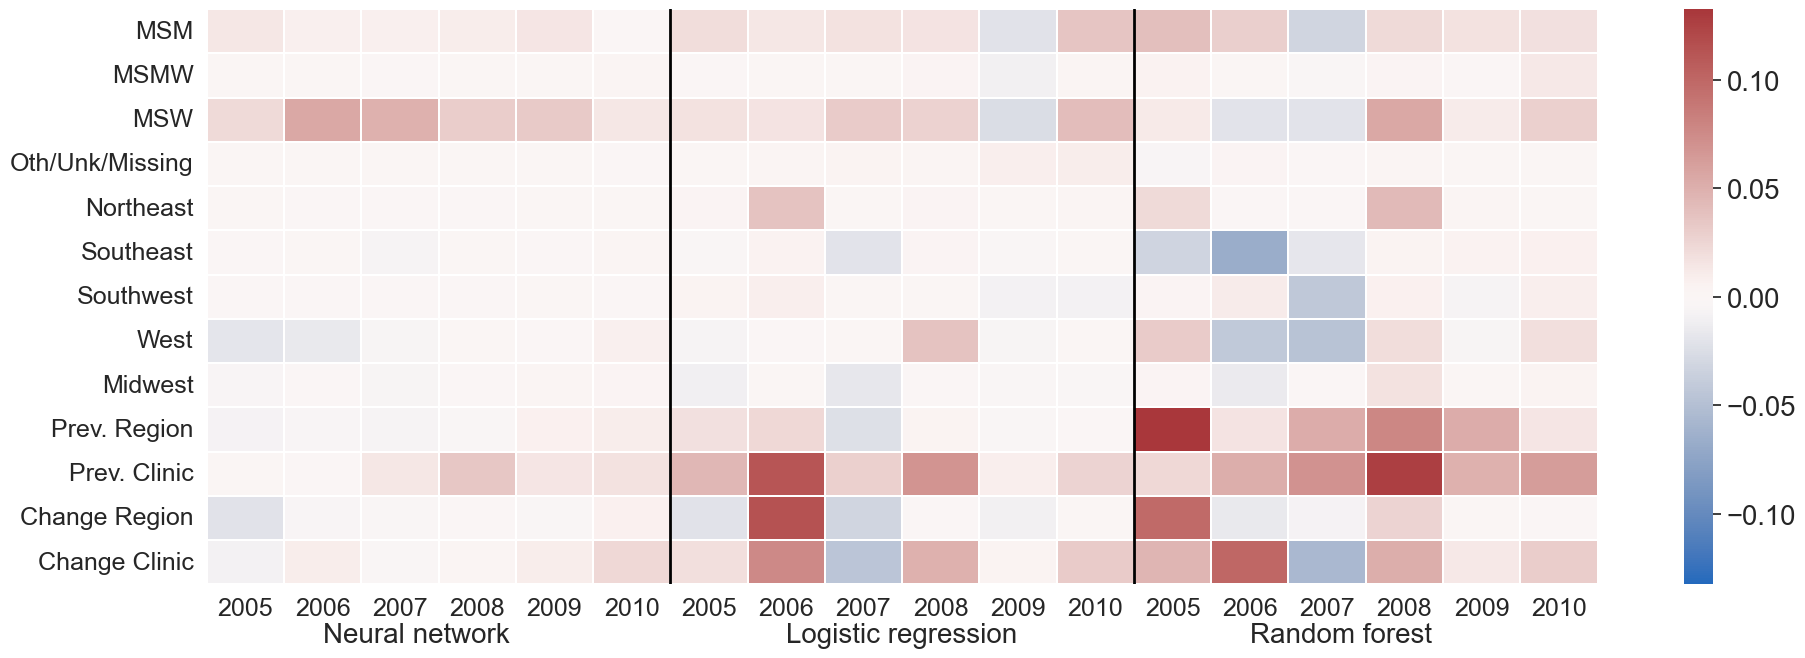

In [35]:
## Figure 1: Graph of important features

fig, ax = plt.subplots(figsize=(20,7))
sb.set(font_scale=1.8)
x_axis_labels = [2005,2006,2007,2008,2009,2010]*3
y_axis_labels =['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','Prev. Region', 'Prev. Clinic','Change Region', 'Change Clinic']

ax.tick_params(axis='both', which='major', labelsize=18)

sb.heatmap(imporances_all_models,fmt="",cmap='vlag',linewidths=0.30,ax=ax, xticklabels = x_axis_labels, yticklabels = y_axis_labels, vmin =-abs(imporances_all_models.max()).max(), vmax = abs(imporances_all_models.max()).max())
ax.text((ax.get_xlim()[1])/18 * 1.5, (ax.get_ylim()[0]) + (ax.get_ylim()[0])*0.10, "Neural network", fontsize=20)
ax.text((ax.get_xlim()[1])/18 * 7.5, (ax.get_ylim()[0]) + (ax.get_ylim()[0])*0.10, "Logistic regression", fontsize=20)
ax.text((ax.get_xlim()[1])/18 * 13.5 , (ax.get_ylim()[0]) + (ax.get_ylim()[0])*0.10, "Random forest", fontsize=20)
ax.axvline((ax.get_xlim()[1])/18 * 6, color = "black", linewidth = 2)
ax.axvline((ax.get_xlim()[1])/18 * 12, color = "black", linewidth = 2)

plt.tight_layout()

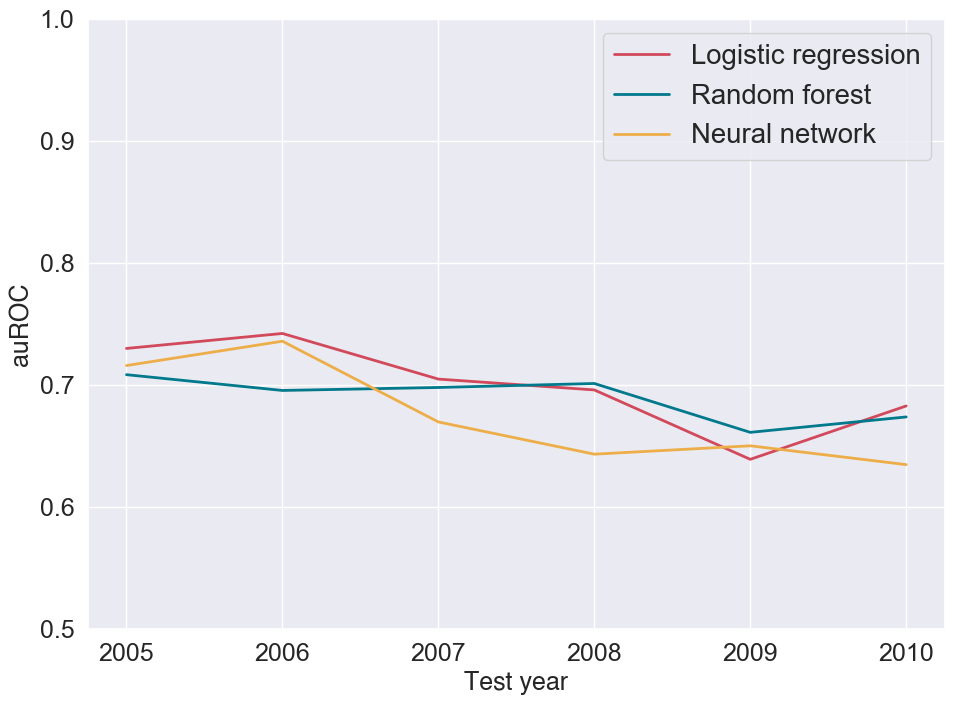

In [36]:
## Figure 2: auROC by model and year 

fig, axs = plt.subplots(figsize=(10, 7.5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
years = np.array(range(2005, 2011))
axs.tick_params(axis='both', which='major', labelsize=18)


axs.plot(test_years, ROC_by_year[0].values(),linewidth = 2, label = "Logistic regression", color = "#d1495b")
axs.plot(test_years, ROC_by_year[1].values(),linewidth = 2, label = "Random forest", color = "#00798c")
axs.plot(test_years, ROC_by_year[2].values(),linewidth = 2, label = "Neural network", color = "#edae49")

axs.set_ylabel("auROC", fontsize = 18, **hfont)
axs.set_xlabel("Test year",  fontsize = 18,**hfont)
axs.set_ylim([0.5,1])
axs.legend()
plt.tight_layout()


In [ ]:
## Plot labes - needed for all subsequent graphs 
text_for_graph = ['0', '0.2', '0.4', '0.6', '0.8', '1']
indices = [0,20,40,60,80,100]
labels = ["A", "B", "C", "D", "E", "F" ]


NameError: name 'np' is not defined

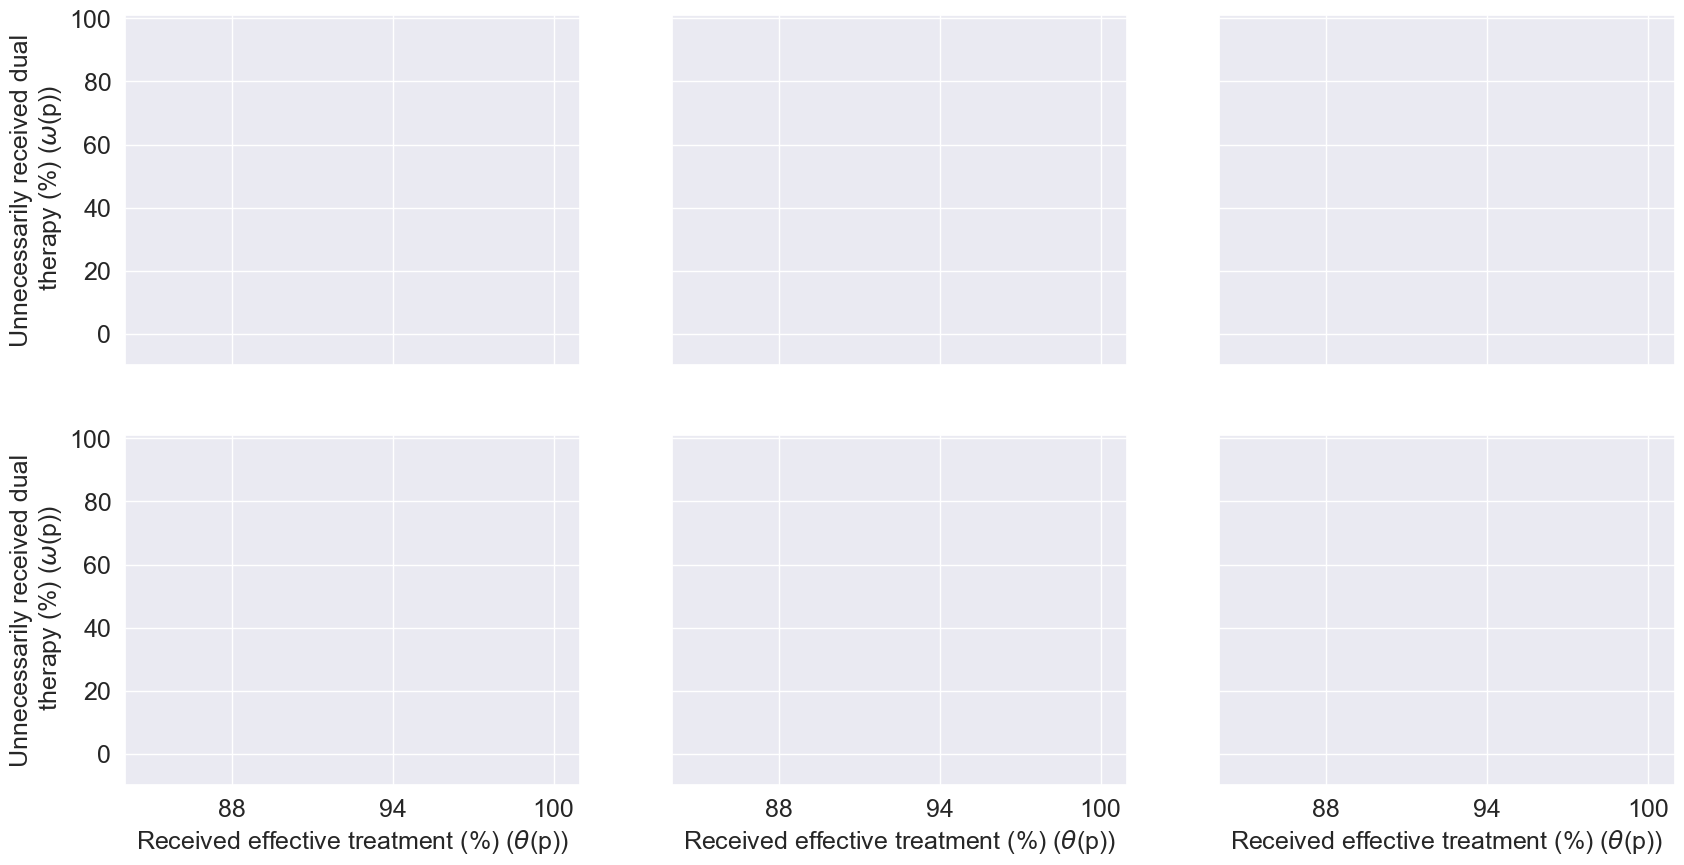

In [23]:
## Figure 3: proportion getting effective treatment and unnecessary dual therapy (+ S)

###### Effect of threshold on year-by-year for logistic regression
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received dual\n therapy (%) ($\omega$(p))", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received dual\n therapy (%) ($\omega$(p))", fontsize = 18)
axs[1,0].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)
axs[1,1].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)
axs[1,2].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(70,100,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(70,100,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(70,100,6), fontsize=18,**hfont)

axs[0,0].set_ylim([0-10,101])
axs[0,0].set_xlim([84, 101])
axs = axs.ravel()

threshold_seq = np.linspace(0,1,101)

i = 0

for model_type in range(len(model_types)):
    for year in years:
        years_train = np.array(range(year - 5, year))
        
        #Retrieve data (from previous loop)
        if model_type == 0:
            model = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year[model_type][year]['solver'], C = best_hyperparameters_by_year[model_type][year]['C'], penalty = best_hyperparameters_by_year[model_type][year]['penalty'])
        
        elif model_type == 1:
            model = RandomForestClassifier(n_estimators = best_hyperparameters_by_year[model_type][year]['n_estimators'], min_samples_split = best_hyperparameters_by_year[model_type][year]['min_samples_split'], min_samples_leaf=best_hyperparameters_by_year[model_type][year]['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters_by_year[model_type][year]['max_depth'], random_state = 10)

        else:
            model = MLPClassifier(solver = 'lbfgs', activation = best_hyperparameters_by_year[model_type][year]['activation'], max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters_by_year[model_type][year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year[model_type][year]['alpha'], random_state=10, learning_rate =best_hyperparameters_by_year[model_type][year]['learning_rate'])

        test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year], years_train = years_train, model_type = model_type)
        
        ## Fit model
        model_fit = model.fit(X_train, y_train)
        y_predict_test = model_fit.predict(X_test)
        y_predict_proba = model_fit.predict_proba(X_test)
        
        ## Get effective treatment and unnecessary dual 
        sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

        #plot
        axs[i].plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)
        axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=12, color = "black", label = "Dual")
        axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "Cipro")
        axs[i].plot([100, (1-cipro_R_prev)*100], [(1-cipro_R_prev)*100, 0], color = "#808080", linestyle="--")
        axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[model_type], fontsize = 30, **hfont)
        axs[i].set_title(year,fontsize=20)  
        axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 25, f'auROC: {round(ROC_by_year_rf[year], 3)}', fontsize = 16, **hfont)
        axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 35, f'CIP-R: {round(cipro_R_prev*100, 3)}%', fontsize = 16, **hfont)
    
        x = 0
        for index in indices:
            axs[i].plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
            if index == 100:
                axs[i].text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index] - 1, text_for_graph[x], size = 12)
            elif index == 0:
                axs[i].text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index], text_for_graph[x], size = 12)
            elif (get_effective_threshold[index] > 95) & (get_effective_threshold[index] < 99.6):
                if abs(get_effective_threshold[index] - get_effective_threshold[index-20]) < 0.5:
                    if (incorrectly_get_X_threshold[index] - incorrectly_get_X_threshold[index-20] < 1):
                        axs[i].text(get_effective_threshold[index]*0.9875, incorrectly_get_X_threshold[index]*1.01, text_for_graph[x], size = 12)#, color = "blue")
                    else:
                        axs[i].text(get_effective_threshold[index]*0.9875, incorrectly_get_X_threshold[index]*0.95, text_for_graph[x], size = 12)#, color = "green")
                else:
                    axs[i].text(get_effective_threshold[index]*1.005, incorrectly_get_X_threshold[index]*0.95, text_for_graph[x], size = 12)#, color = "red")
            
            else:
                axs[i].text(get_effective_threshold[index]- 0.01, incorrectly_get_X_threshold[index]-5, text_for_graph[x], size = 12)
            
            x = x+1
        i += 1

    plt.tight_layout()
    axs[0].legend()
    plotname = "Effective_vs_unnecessary_treatment" + model_types[model_type] + ".png"
    #plt.savefig("plotname", dpi = 600)


In [ ]:
## Figure 4: LOOCV
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

### Leave one out validation for random forest
polygon_important0 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important1 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important2 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important3 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important4 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important5 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received dual\n therapy (%) ($\omega$(p))", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received dual\n therapy (%) ($\omega$(p))", fontsize = 18)
axs[1,0].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)
axs[1,1].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)
axs[1,2].set_xlabel("Received effective treatment (%) " +  r"($\theta$(p))", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(45,100,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(45,100,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(45,100,6), fontsize=18,**hfont)


axs = axs.ravel()
i = 0
for model_type in range(len(model_types)):
  for year in years: 
      years_train = np.array(range(year - 5, year))

      # First do for all clinics 

      CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
      CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
        
      #Retrieve data (from previous loop)
      if model_type == 0:
            model = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year[model_type][year]['solver'], C = best_hyperparameters_by_year[model_type][year]['C'], penalty = best_hyperparameters_by_year[model_type][year]['penalty'])
        
      elif model_type == 1:
            model = RandomForestClassifier(n_estimators = best_hyperparameters_by_year[model_type][year]['n_estimators'], min_samples_split = best_hyperparameters_by_year[model_type][year]['min_samples_split'], min_samples_leaf=best_hyperparameters_by_year[model_type][year]['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters_by_year[model_type][year]['max_depth'], random_state = 10)

      else:
            model = MLPClassifier(solver = 'lbfgs', activation = best_hyperparameters_by_year[model_type][year]['activation'], max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters_by_year[model_type][year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year[model_type][year]['alpha'], random_state=10, learning_rate =best_hyperparameters_by_year[model_type][year]['learning_rate'])

      test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year], years_train = years_train, model_type = model_type)
        
      ## Fit aggregate model 
      model_fit = model.fit(X_train, y_train)
      y_predict_test = model_fit.predict(X_test)
      y_predict_proba = model_fit.predict_proba(X_test)
  
      ## Get effective treatment and unnecessary dual for aggregate model
      senstivitity_threshold_all, specificity_threshold_all, get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)


      clinics = CIP_data_testing_years["CLINIC"].unique()
      for clinic in clinics: 
          test_data, train_data, X_train, y_train, X_test, y_test, cipro_R =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop.loc[CIP_data_no_drop['CLINIC'] != clinic], year = year, feature_names = best_features_by_year[model_type][year], years_train = years_train, model_type = model_type)


          if cipro_R > 0: 
            try:

                model_fit = model.fit(X_train, y_train)
                y_predict_test = model_fit.predict(X_test)
                y_predict_proba = model_fit.predict_proba(X_test)
                senstivitity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)

                axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = "#e5e5e5", linewidth = 3)
                axs[i].plot(100, (1 - cipro_R)*100, marker='.', ls='none', ms=18, color = "#e5e5e5")
                axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=14, color = "#e5e5e5")
    

            
            except ValueError: #sometimes it's a very small number of CIPR in sample so need to change sampling strategy
              try:
                #get data
                oversample = RandomOverSampler(sampling_strategy = 'minority',random_state=42)
                X_train, y_train = oversample.fit_resample(X_train,y_train)
                X_test, y_test = oversample.fit_resample(X_test,y_test)
                #fit  
                model_fit_train = model_rf.fit(X_train, y_train)
                y_predict_test = model_fit_train.predict(X_test)
                y_predict_proba = model_fit_train.predict_proba(X_test)
                senstivitity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)

                axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = "#e5e5e5", linewidth = 3)
                axs[i].plot(100, (1 - cipro_R)*100, marker='.', ls='none', ms=18, color = "#e5e5e5")
                axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=14, color = "#e5e5e5")

              except ValueError:
                print('x')
                pass


      axs[i].plot(get_effective_threshold_all, incorrectly_get_X_threshold_all,color = "black", linewidth = 3) #plot for aggregate model
      axs[i].plot(100, 100 - cipro_R_prev*100, marker='s', ls='none', ms=10, color = "#b56576")
      axs[i].plot((100-cipro_R_prev*100), 0, marker='*', ls='none', ms=14, color = "#b56576")
      axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
      axs[i].axvline(x = 95, color = 'black', linestyle="--")

      axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 15, f'auROC: {round(ROC_by_year_rf[year], 3)}', fontsize = 16, **hfont)
      axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 25, f'CIP-R: {round(cipro_R_prev*100, 3)}', fontsize = 16, **hfont)
      for index in indices:
          axs[i].plot(get_effective_threshold_all[index], incorrectly_get_X_threshold_all[index], marker='.', ls='none', ms=11, color = "#b56576")
      axs[i].set_title(year,fontsize=20)   

      i += 1   


  axs[0].add_patch(polygon_important0)
  axs[1].add_patch(polygon_important1)
  axs[2].add_patch(polygon_important2)
  axs[3].add_patch(polygon_important3)
  axs[4].add_patch(polygon_important4)
  axs[5].add_patch(polygon_important5)
  plt.tight_layout()
  axs[0].legend()
  plotname = "LOOCV_effective_vs_unnecessary_treatment" + model_types[model_type] + ".png"
  #plt.savefig("plotname", dpi = 600)


In [ ]:
## SI: sensivitity and specificity 

###### Effect of threshold on year-by-year for logistic regression
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel('Percentage (%)')
axs[1,0].set_ylabel('Percentage (%)')
axs[1,0].set_xlabel('Threshold (p)')
axs[1,1].set_xlabel('Threshold (p)')
axs[1,2].set_xlabel('Threshold (p)')

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(70,100,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(70,100,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(70,100,6), fontsize=18,**hfont)

axs[0,0].set_ylim([0-10,101])
axs[0,0].set_xlim([84, 101])
axs = axs.ravel()

threshold_seq = np.linspace(0,1,101)

i = 0

for model_type in range(len(model_types)):
    for year in years:
        years_train = np.array(range(year - 5, year))
        
        #Retrieve data (from previous loop)
        if model_type == 0:
            model = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year[model_type][year]['solver'], C = best_hyperparameters_by_year[model_type][year]['C'], penalty = best_hyperparameters_by_year[model_type][year]['penalty'])
        
        elif model_type == 1:
            model = RandomForestClassifier(n_estimators = best_hyperparameters_by_year[model_type][year]['n_estimators'], min_samples_split = best_hyperparameters_by_year[model_type][year]['min_samples_split'], min_samples_leaf=best_hyperparameters_by_year[model_type][year]['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters_by_year[model_type][year]['max_depth'], random_state = 10)

        else:
            model = MLPClassifier(solver = 'lbfgs', activation = best_hyperparameters_by_year[model_type][year]['activation'], max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters_by_year[model_type][year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year[model_type][year]['alpha'], random_state=10, learning_rate =best_hyperparameters_by_year[model_type][year]['learning_rate'])

        test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year], years_train = years_train, model_type = model_type)
        
        ## Fit model
        model_fit = model.fit(X_train, y_train)
        y_predict_test = model_fit.predict(X_test)
        y_predict_proba = model_fit.predict_proba(X_test)
        
        ## Get effective treatment and unnecessary dual 
        sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)

        #plot
        axs[i].plot(threshold_seq, sensitivity_threshold, color = "#c8b6ff", label = r"Sensitivity ($\alpha$(p))", linewidth = 2)
        axs[i].plot(threshold_seq, specificity_threshold, color = "#99d98c", label = r"Specificity ($\beta$(p))", linewidth = 2)
        axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
        i += 1

    plt.tight_layout()
    axs[0].legend()
    plotname = "Sensitivity_specificity" + model_types[model_type] + ".png"
    #plt.savefig("plotname", dpi = 600)


In [ ]:
## SI: model performance
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
colors = ["#6667ab", "#f18aad", "#ea6759", "#f88f58", "#f3c65f", "#8bc28c"]

axs[0,0].set_ylabel('F1 score', fontsize = 18, **hfont)
axs[1,0].set_ylabel('MCC', fontsize = 18, **hfont)
axs[1,0].set_xlabel("Threshold (p)", fontsize = 18, **hfont)
axs[1,1].set_xlabel("Threshold (p)", fontsize = 18, **hfont)
axs[1,2].set_xlabel("Threshold (p)", fontsize = 18, **hfont)

axs[0,0].set_yticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)

axs[0,0].tick_params(axis='both', labelsize=18)
axs[0,1].tick_params(axis='both', labelsize=18)
axs[0,2].tick_params(axis='both', labelsize=18)
axs[1,0].tick_params(axis='both', labelsize=18)
axs[1,1].tick_params(axis='both', labelsize=18)
axs[1,2].tick_params(axis='both', labelsize=18)

axs[0,0].set_ylim([0-.010,1])
axs[0,0].set_xlim([0, 1])

axs = axs.ravel()


for i in range(len(model_types)): #i is stand-in for "model type"
    x = 0
    
    if model_type == 0:
        for year in test_years: 
            years_train = np.array(range(year - 5, year))
            model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters_by_year[i][year]['hidden_layer_sizes'], alpha =  best_hyperparameters_by_year[i][year]['alpha'], random_state=10, learning_rate = 'adaptive' )
            test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[i][year], years_train = years_train, model_type = i)

            ## fit model
            model_fit = model_nn.fit(X_train, y_train)
            y_predict_test = model_fit.predict(X_test)
            y_predict_proba = model_fit.predict_proba(X_test)
            f1_score_for_year, mcc_score_for_year = f1_mcc_score_threshold(threshold_seq, y_predict_proba, y_test)
            axs[i].plot(threshold_seq, f1_score_for_year, color = colors[x], linewidth = 3, label = year)
            axs[i + 3].plot(threshold_seq, mcc_score_for_year, color = colors[x], linewidth = 3)

            x += 1
        axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.05, labels[i], fontsize = 20, **hfont)
        axs[i+3].text(axs[i + 3].get_xlim()[0] , axs[i + 3].get_ylim()[1] + 0.05, labels[i + 3], fontsize = 20, **hfont)
        axs[i].set_title("Neural network",fontsize=20)
        axs[i].legend()


    if i == 1:
        for year in test_years: 
            years_train = np.array(range(year - 5, year))
            model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year[i][year]['solver'], C = best_hyperparameters_by_year[i][year]['C'], penalty = best_hyperparameters_by_year[i][year]['penalty'])
            test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[i][year], years_train = years_train, model_type = i)

            ## fit model
            model_fit_train = model_lr.fit(X_train, y_train)
            y_predict_test = model_fit_train.predict(X_test)
            y_predict_proba = model_fit_train.predict_proba(X_test)
            f1_score_for_year, mcc_score_for_year = f1_mcc_score_threshold(threshold_seq, y_predict_proba, y_test)
            axs[i].plot(threshold_seq, f1_score_for_year, color = colors[x], linewidth = 3, label = year)
            axs[i + 3].plot(threshold_seq, mcc_score_for_year, color = colors[x], linewidth = 3, label = year)

            x += 1
   
        axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.05, labels[i], fontsize = 20, **hfont)
        axs[i+3].text(axs[i + 3].get_xlim()[0] , axs[i + 3].get_ylim()[1] + 0.05, labels[i + 3], fontsize = 20, **hfont)
        axs[i].set_title("Logistic regression",fontsize=20)

    
    if i == 2:
        for year in test_years: 
            years_train = np.array(range(year - 5, year))
            model_rf = RandomForestClassifier(n_estimators = best_hyperparameters_by_year[i][year]['n_estimators'], min_samples_split = best_hyperparameters_by_year[i][year]['min_samples_split'], min_samples_leaf=best_hyperparameters_by_year[i][year]['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters_by_year[i][year]['max_depth'], random_state = 10)
            test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[i][year], years_train = years_train, model_type = i)
            
            ## fit model
            model_fit_train = model_rf.fit(X_train, y_train)
            y_predict_test = model_fit_train.predict(X_test)
            y_predict_proba = model_fit_train.predict_proba(X_test)
            f1_score_for_year, mcc_score_for_year = f1_mcc_score_threshold(threshold_seq, y_predict_proba, y_test)

            axs[i].plot(threshold_seq, f1_score_for_year, color = colors[x], linewidth = 3, label = year)
            axs[i + 3].plot(threshold_seq, mcc_score_for_year, color = colors[x], linewidth = 3, label = year)

            x += 1
        axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.05, labels[i], fontsize = 20, **hfont)
        axs[i+3].text(axs[i + 3].get_xlim()[0] , axs[i + 3].get_ylim()[1] + 0.05, labels[i + 3], fontsize = 20, **hfont)
        axs[i].set_title("Random forest",fontsize=20)

plt.tight_layout()
#plt.savefig('F1_MCC_score_all_years_all_models.png', dpi = 600)
